# mlbox do some hyper param analysis

In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import sys
import tempfile
import shutil
import warnings

import mlflow
import tempfile

In [2]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1287: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  _pywrap_tensorflow.RegisterType("Sequence", _collections.Sequence)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/training/tracking/object_identity.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class ObjectIdentityDictionary(collections.MutableMapping):
/opt/conda/lib/python3.7/site-packages/keras/callbacks.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [3]:
sys.path.append('..')
from utils.kaggle import get_global_parameters
from utils.mlflow_experiments import retrieve_artifacts, extract_run_data_for_experiment
global_parms = get_global_parameters()

In [4]:
global_parms

{'PROJ_DIR': '/opt/project'}

In [5]:
TMPDIR= tempfile.mkdtemp()

In [6]:
MLBOX_SAVE='mlbox_save'

In [7]:
try:
    shutil.rmtree(MLBOX_SAVE)
except:
    pass

## Retrieve training data

In [8]:
# retrieve run_id for desired feature set to test
run_info = extract_run_data_for_experiment('feature_set')
RUN_ID = run_info.loc[run_info['mlflow.runName'] == 'feature_set_0'].run_id.values[0]

retrieve_artifacts(RUN_ID, '.', TMPDIR)

In [9]:
os.listdir(TMPDIR)

['fs_train_df.pkl.zip',
 'fs_valid_df.pkl.zip',
 'fs_test_df.pkl.zip',
 'kag_test_df.pkl.zip']

In [10]:
pd.read_pickle(os.path.join(TMPDIR,'fs_train_df.pkl.zip')) \
    .sample(frac=0.5).drop(['TransactionID', 'TransactionDT', 'addr1'], axis=1) \
    .to_csv(os.path.join(TMPDIR,'fs_train_df.csv'),index=False)

In [11]:
pd.read_pickle(os.path.join(TMPDIR,'fs_test_df.pkl.zip')) \
    .drop(['isFraud', 'TransactionID', 'TransactionDT', 'addr1'], axis=1) \
    .to_csv(os.path.join(TMPDIR,'fs_test_df.csv'),index=False)

In [12]:
paths = [os.path.join(TMPDIR,'fs_test_df.csv'), os.path.join(TMPDIR,'fs_train_df.csv')]

In [13]:
rd = Reader(sep=',', to_path=MLBOX_SAVE)
df = rd.train_test_split(paths, 'isFraud')



reading csv : fs_test_df.csv ...
cleaning data ...
CPU time: 8.40943169593811 seconds

reading csv : fs_train_df.csv ...
cleaning data ...
CPU time: 18.707637310028076 seconds

> Number of common features : 131

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 18
> Number of numerical features: 113
> Number of training samples : 136189
> Number of test samples : 59054

> Top sparse features (% missing values on train set):
D7       88.7
id_04    81.0
D8       78.5
D9       78.5
id_10    78.5
dtype: float64

> Task : classification
0.0    128891
1.0      7298
Name: isFraud, dtype: int64

encoding target ...


In [14]:
dft = Drift_thresholder(to_path=MLBOX_SAVE)
df = dft.fit_transform(df)


computing drifts ...
CPU time: 26.486151218414307 seconds

> Top 10 drifts

('V283', 0.19392904772153763)
('V308', 0.1827915865385641)
('V128', 0.14458302124146938)
('id_29', 0.12712505846720035)
('D3', 0.12629373985540981)
('id_28', 0.12602481345910665)
('D5', 0.11394767346068191)
('id_15', 0.11295934910056138)
('id_16', 0.11256902240638089)
('D8', 0.08649660382151936)

> Deleted variables : []
> Drift coefficients dumped into directory : mlbox_save


In [15]:
opt = Optimiser(scoring = 'roc_auc', n_folds = 5, to_path=MLBOX_SAVE)


/opt/conda/lib/python3.7/site-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'mlbox_save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


In [16]:

opt.evaluate(None, df)


No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was 


MEAN SCORE : roc_auc = 0.8752565818585275
VARIANCE : 0.005424244677246336 (fold 1 = 0.8840700352362839, fold 2 = 0.8744091011024585, fold 3 = 0.8700086592900179, fold 4 = 0.8782266663355499, fold 5 = 0.8695684473283268)
CPU time: 52.727686166763306 seconds



0.8752565818585275

In [17]:
#%%capture cap --no-stderr
space = {
    
        'ne__numerical_strategy':{"search":"choice",
                                 "space":[0]},
        'ce__strategy':{"search":"choice",
                        "space":["label_encoding","random_projection", "entity_embedding"]}, 
        'fs__threshold':{"search":"uniform",
                        "space":[0.01,0.3]},    
        'est__max_depth':{"search":"choice",
                                  "space":[3,5, 7, 9, 11, 13]},
        'est__n_estimators': {'search':'choice', 'space':[50, 100, 150, 200, 400, 800, 1200]}
    
        }

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = opt.optimise(space, df)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}    
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2199021839874096}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 100, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
  0%|          | 0/40 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.16392649211815202}       
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 11, 'n_estimators': 200, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : roc_auc = 0.8680213600725143                                        
VARIANCE : 0.004005594222238363 (fold 1 = 0.8748128321501998, fold 2 = 0.8668949018861789, fold 3 = 0.8650236157624054, fold 4 = 0.8698726342193913, fold 5 = 0.863502816344396)
CPU time: 217.69819116592407 seconds                                             
##################################################### testing hyper-parameters...

CPU time: 338.9890639781952 seconds                                               
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}       
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2595065219111404}         
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 200, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : roc_auc = 0.858507372915

MEAN SCORE : roc_auc = 0.8642391333680773                                           
VARIANCE : 0.004247623072592091 (fold 1 = 0.8712269783146205, fold 2 = 0.863982614462582, fold 3 = 0.8608303167084177, fold 4 = 0.866054670630779, fold 5 = 0.8591010867239871)
CPU time: 284.0964801311493 seconds                                                 
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}         
>>> CA ENCODER :{'strategy': 'random_projection'}                                   
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06623804333940053}          
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 9, 'n_estimators': 800, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'n_estimators': 1200, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : roc_auc = 0.8761870467763874                                           
VARIANCE : 0.006215945598897297 (fold 1 = 0.8866126299042387, fold 2 = 0.8765039106299627, fold 3 = 0.8695758276410701, fold 4 = 0.8781311069031401, fold 5 = 0.8701117588035258)
CPU time: 284.6590313911438 seconds                                                 
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'nu

CPU time: 277.21440267562866 seconds                                              
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}       
>>> CA ENCODER :{'strategy': 'random_projection'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10541346283811931}        
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 11, 'n_estimators': 50, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : roc_auc = 0.853644704312

MEAN SCORE : roc_auc = 0.8290992273414608                                         
VARIANCE : 0.005108149403007574 (fold 1 = 0.8369130363622934, fold 2 = 0.8232291100938786, fold 3 = 0.8275436631214681, fold 4 = 0.832933622461327, fold 5 = 0.8248767046683363)
CPU time: 214.41054368019104 seconds                                              
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}       
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.13516993263784385}        
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 11, 'n_estimators': 1200, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 

In [19]:
best

{'ce__strategy': 'random_projection',
 'est__max_depth': 11,
 'est__n_estimators': 1200,
 'fs__threshold': 0.17540488667771706,
 'ne__numerical_strategy': 0}


fitting the pipeline ...


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU time: 67.07253909111023 seconds


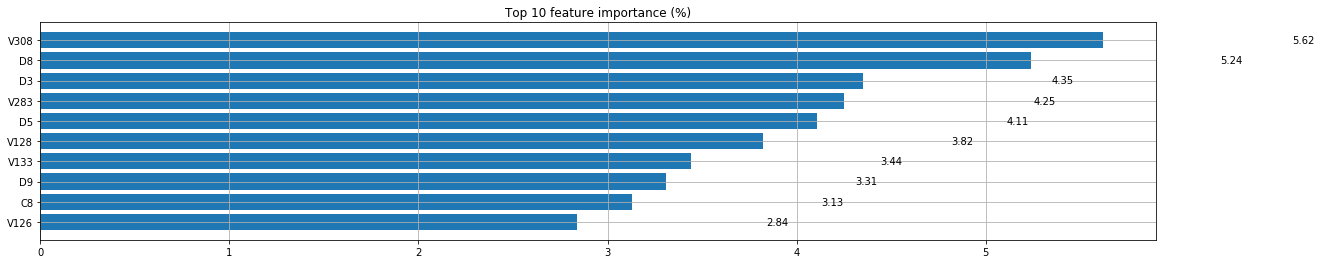


> Feature importances dumped into directory : mlbox_save

predicting ...
CPU time: 3.970404863357544 seconds

> Overview on predictions : 

        0.0       1.0  isFraud_predicted
0  0.995906  0.004094                  0
1  0.978855  0.021145                  0
2  0.978867  0.021133                  0
3  0.993677  0.006323                  0
4  0.992138  0.007862                  0
5  0.859984  0.140016                  0
6  0.966562  0.033438                  0
7  0.995409  0.004591                  0
8  0.983931  0.016069                  0
9  0.826079  0.173921                  0

dumping predictions into directory : mlbox_save ...


In [20]:
%matplotlib inline
prd = Predictor(to_path=MLBOX_SAVE)
prd.fit_predict(best, df)

In [21]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`);

<IPython.core.display.Javascript object>

In [22]:
notebookName

'automl_mlbox_hyperparm.ipynb'

In [23]:
# remove joblib artifacts from MLBOX_SAVE, these are not needed
shutil.rmtree(os.path.join(MLBOX_SAVE,'joblib'))

In [24]:
# save sample as mlflow artifact
experiment_id = mlflow.set_experiment('hyperparms')

#%%
with mlflow.start_run(experiment_id=experiment_id, run_name='mlbox_inital_hyperparm3'):
    mlflow.log_param('notebook_name',notebookName)
    mlflow.log_artifacts(MLBOX_SAVE)


## Clean-up

In [25]:
shutil.rmtree(TMPDIR)

In [26]:
pd.__version__

'0.24.2'

In [27]:
!echo $PATH


/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
